# Project Situated AI Assignment 2: Robotics and Reinforcement Learning

This notebook provides a quickstart for training RL agents on Gymnasium Robotics environments using RL Baselines3 Zoo.

## Part 1: Setup

Run these cells once to install dependencies.

### Collab Setup

In [2]:
# # Install system dependencies (Colab only - skip if running locally)
# !apt-get update && apt-get install -q -y swig cmake ffmpeg freeglut3-dev xvfb

In [4]:
# # Setup virtual display for video recording (Colab only)
# import os
# os.system("Xvfb :1 -screen 0 1024x768x24 &")
# os.environ['DISPLAY'] = ':1'

In [5]:
# # Mount your drive to the session
# from google.colab import drive
# drive.mount('/content/drive')

### General Setup

In [6]:
# # Install Python packages
# !pip install -q rl-zoo3
# !pip install -q -e git+https://github.com/Farama-Foundation/Gymnasium-Robotics.git#egg=gymnasium-robotics

In [9]:
# # Create wrapper for record_video (rl_zoo3.record_video doesn't support --gym-packages)
# with open('record_video.py', 'w') as f:
#     f.write(
#         '#!/usr/bin/env python\n'
#         'import gymnasium_robotics\n'
#         'import runpy\n'
#         'runpy.run_module("rl_zoo3.record_video", run_name="__main__")\n'
#     )

## Part 2: Configure Hyperparameters

RL Zoo expects hyperparameters in a YAML file. Modify these to experiment with different settings.

In [4]:
import optuna

import gymnasium as gym
import gymnasium_robotics

from optuna import trial, study


c:\Users\robin\Desktop\SituatedAI\proj_situated_2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def objective(trial: trial.Trial):
    x = trial.suggest_float("x", 0, 10)
    return x


study = optuna.create_study(
    study_name="robotics_experiment",
    storage="sqlite:///db.sqlite3",
    direction="minimize",  # or "maximize"
    load_if_exists=True
)
study.optimize(objective, n_trials=3)

[I 2026-01-20 18:35:05,511] Using an existing study with name 'robotics_experiment' instead of creating a new one.
[I 2026-01-20 18:35:05,542] Trial 6 finished with value: 4.123252393007534 and parameters: {'x': 4.123252393007534}. Best is trial 0 with value: 0.42904966810839107.
[I 2026-01-20 18:35:05,565] Trial 7 finished with value: 1.4488809169511363 and parameters: {'x': 1.4488809169511363}. Best is trial 0 with value: 0.42904966810839107.
[I 2026-01-20 18:35:05,587] Trial 8 finished with value: 1.1203628370782714 and parameters: {'x': 1.1203628370782714}. Best is trial 0 with value: 0.42904966810839107.


In [8]:
import optuna
import gymnasium as gym
import gymnasium_robotics
from stable_baselines3 import DDPG, A2C, PPO
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np


gym.register_envs(gymnasium_robotics)

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256]),
        "tau": trial.suggest_float("tau", 0.001, 0.05, log=True),
        "gamma": trial.suggest_float("gamma", 0.95, 0.995),
        "noise_std": trial.suggest_float("noise_std", 0.05, 0.5),
        "net_arch": trial.suggest_categorical("net_arch", ["small", "medium", "large"]),
    }
    
    net_arch_map = {"small": [64, 64], "medium": [256, 256], "large": [400, 300]}
    
    env = gym.make("FetchReachDense-v4")
    noise = OrnsteinUhlenbeckActionNoise(
        mean=np.zeros(env.action_space.shape[0]),
        sigma=params["noise_std"] * np.ones(env.action_space.shape[0])
    )
    
    model = DDPG(
        policy="MultiInputPolicy",
        env=env,
        learning_rate=params["learning_rate"],
        batch_size=params["batch_size"],
        tau=params["tau"],
        gamma=params["gamma"],
        buffer_size=100000,
        learning_starts=1000,
        action_noise=noise,
        policy_kwargs=dict(net_arch=net_arch_map[params["net_arch"]]),
        verbose=0,
    )
    
    model.learn(total_timesteps=25000)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
    env.close()
    
    return mean_reward

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"Best reward: {study.best_trial.value}")
print(f"Best params: {study.best_trial.params}")

[I 2026-01-20 18:35:29,401] A new study created in memory with name: no-name-678fa466-ec24-40ce-927e-c71e9c900cdd
  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\robin\Desktop\SituatedAI\proj_situated_2\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
Best trial: 0. Best value: -0.964246:   3%|▎         | 1/30 [03:01<1:27:43, 181.49s/it]

[I 2026-01-20 18:38:30,887] Trial 0 finished with value: -0.9642462206073106 and parameters: {'learning_rate': 0.007109120071742631, 'batch_size': 256, 'tau': 0.0012654279458927493, 'gamma': 0.9581045482884205, 'noise_std': 0.07405688815404089, 'net_arch': 'small'}. Best is trial 0 with value: -0.9642462206073106.


Best trial: 0. Best value: -0.964246:   7%|▋         | 2/30 [06:27<1:31:18, 195.65s/it]

[I 2026-01-20 18:41:56,458] Trial 1 finished with value: -10.207930801063776 and parameters: {'learning_rate': 1.4908520068559005e-05, 'batch_size': 256, 'tau': 0.0010122717332893179, 'gamma': 0.9500971536994709, 'noise_std': 0.30947265325345985, 'net_arch': 'small'}. Best is trial 0 with value: -0.9642462206073106.


Best trial: 0. Best value: -0.964246:  10%|█         | 3/30 [09:55<1:30:38, 201.41s/it]

[I 2026-01-20 18:45:24,710] Trial 2 finished with value: -8.227335276082158 and parameters: {'learning_rate': 2.6594977732527383e-05, 'batch_size': 256, 'tau': 0.04895718085974698, 'gamma': 0.9946631977363998, 'noise_std': 0.16437244647198346, 'net_arch': 'small'}. Best is trial 0 with value: -0.9642462206073106.


Best trial: 3. Best value: -0.837151:  13%|█▎        | 4/30 [13:15<1:27:00, 200.78s/it]

[I 2026-01-20 18:48:44,526] Trial 3 finished with value: -0.8371508242329583 and parameters: {'learning_rate': 0.000444015289081669, 'batch_size': 256, 'tau': 0.0028324653996480665, 'gamma': 0.9544451792868114, 'noise_std': 0.25909038377076193, 'net_arch': 'large'}. Best is trial 3 with value: -0.8371508242329583.


Best trial: 3. Best value: -0.837151:  17%|█▋        | 5/30 [16:28<1:22:31, 198.05s/it]

[I 2026-01-20 18:51:57,745] Trial 4 finished with value: -41.438329092413184 and parameters: {'learning_rate': 0.0055037560912799795, 'batch_size': 128, 'tau': 0.014275873469309525, 'gamma': 0.9889765122782626, 'noise_std': 0.46425183074888254, 'net_arch': 'medium'}. Best is trial 3 with value: -0.8371508242329583.


Best trial: 3. Best value: -0.837151:  20%|██        | 6/30 [19:03<1:13:22, 183.44s/it]

[I 2026-01-20 18:54:32,811] Trial 5 finished with value: -3.7943292636424304 and parameters: {'learning_rate': 3.0110850758877082e-05, 'batch_size': 64, 'tau': 0.010860866258898693, 'gamma': 0.9874275354234756, 'noise_std': 0.44518220603023023, 'net_arch': 'large'}. Best is trial 3 with value: -0.8371508242329583.


Best trial: 3. Best value: -0.837151:  23%|██▎       | 7/30 [22:13<1:11:05, 185.47s/it]

[I 2026-01-20 18:57:42,453] Trial 6 finished with value: -1.0447333563119172 and parameters: {'learning_rate': 9.89827951570502e-05, 'batch_size': 64, 'tau': 0.0010918254977975307, 'gamma': 0.9571597428437093, 'noise_std': 0.23283866057317787, 'net_arch': 'medium'}. Best is trial 3 with value: -0.8371508242329583.


Best trial: 3. Best value: -0.837151:  27%|██▋       | 8/30 [25:57<1:12:29, 197.72s/it]

[I 2026-01-20 19:01:26,426] Trial 7 finished with value: -5.373082473874092 and parameters: {'learning_rate': 1.7816566283229422e-05, 'batch_size': 128, 'tau': 0.016172416762117284, 'gamma': 0.9587667295806335, 'noise_std': 0.12613911718567766, 'net_arch': 'medium'}. Best is trial 3 with value: -0.8371508242329583.


Best trial: 3. Best value: -0.837151:  30%|███       | 9/30 [29:35<1:11:27, 204.18s/it]

[I 2026-01-20 19:05:04,812] Trial 8 finished with value: -6.045912777259946 and parameters: {'learning_rate': 0.00011652931008321478, 'batch_size': 64, 'tau': 0.04805763417180662, 'gamma': 0.9730161406095947, 'noise_std': 0.1837134194345832, 'net_arch': 'small'}. Best is trial 3 with value: -0.8371508242329583.


Best trial: 3. Best value: -0.837151:  33%|███▎      | 10/30 [33:07<1:08:54, 206.70s/it]

[I 2026-01-20 19:08:37,163] Trial 9 finished with value: -4.532624621130526 and parameters: {'learning_rate': 0.00010457635157531766, 'batch_size': 64, 'tau': 0.04925204222263285, 'gamma': 0.9937369008066741, 'noise_std': 0.26053654890999567, 'net_arch': 'large'}. Best is trial 3 with value: -0.8371508242329583.


Best trial: 10. Best value: -0.62574:  37%|███▋      | 11/30 [36:18<1:03:55, 201.85s/it]

[I 2026-01-20 19:11:47,992] Trial 10 finished with value: -0.6257399923866614 and parameters: {'learning_rate': 0.0007996374523340804, 'batch_size': 256, 'tau': 0.0031350743709614988, 'gamma': 0.9695710764297176, 'noise_std': 0.35615509970242115, 'net_arch': 'large'}. Best is trial 10 with value: -0.6257399923866614.


Best trial: 10. Best value: -0.62574:  40%|████      | 12/30 [39:42<1:00:47, 202.62s/it]

[I 2026-01-20 19:15:12,381] Trial 11 finished with value: -1.1506436170078813 and parameters: {'learning_rate': 0.0012074689773225442, 'batch_size': 256, 'tau': 0.0030167333692367945, 'gamma': 0.9716556631429809, 'noise_std': 0.3648928732636241, 'net_arch': 'large'}. Best is trial 10 with value: -0.6257399923866614.


Best trial: 12. Best value: -0.593601:  43%|████▎     | 13/30 [42:54<56:29, 199.36s/it]  

[I 2026-01-20 19:18:24,235] Trial 12 finished with value: -0.5936011169687845 and parameters: {'learning_rate': 0.0007009836055184231, 'batch_size': 256, 'tau': 0.003388153553365831, 'gamma': 0.9701855396806679, 'noise_std': 0.3597709257829441, 'net_arch': 'large'}. Best is trial 12 with value: -0.5936011169687845.


Best trial: 12. Best value: -0.593601:  47%|████▋     | 14/30 [45:37<50:14, 188.42s/it]

[I 2026-01-20 19:21:07,391] Trial 13 finished with value: -0.6581696326844394 and parameters: {'learning_rate': 0.001093118575245272, 'batch_size': 256, 'tau': 0.00489365736455723, 'gamma': 0.9704536142059342, 'noise_std': 0.3786336641126713, 'net_arch': 'large'}. Best is trial 12 with value: -0.5936011169687845.


Best trial: 12. Best value: -0.593601:  50%|█████     | 15/30 [48:06<44:04, 176.32s/it]

[I 2026-01-20 19:23:35,661] Trial 14 finished with value: -1.170166025031358 and parameters: {'learning_rate': 0.0016862638059167252, 'batch_size': 256, 'tau': 0.002784615669424113, 'gamma': 0.9788315598066536, 'noise_std': 0.3767168684813411, 'net_arch': 'large'}. Best is trial 12 with value: -0.5936011169687845.


Best trial: 12. Best value: -0.593601:  53%|█████▎    | 16/30 [50:32<39:00, 167.18s/it]

[I 2026-01-20 19:26:01,627] Trial 15 finished with value: -0.8067545257741585 and parameters: {'learning_rate': 0.0004419487020813839, 'batch_size': 256, 'tau': 0.0060506182363254946, 'gamma': 0.964971973295661, 'noise_std': 0.3312833807836695, 'net_arch': 'large'}. Best is trial 12 with value: -0.5936011169687845.


Best trial: 12. Best value: -0.593601:  57%|█████▋    | 17/30 [53:59<38:51, 179.38s/it]

[I 2026-01-20 19:29:29,374] Trial 16 finished with value: -1.210898076184094 and parameters: {'learning_rate': 0.0027063572612392433, 'batch_size': 128, 'tau': 0.0019474487305854821, 'gamma': 0.9642696177618331, 'noise_std': 0.4941289629257658, 'net_arch': 'large'}. Best is trial 12 with value: -0.5936011169687845.


Best trial: 12. Best value: -0.593601:  60%|██████    | 18/30 [56:47<35:08, 175.74s/it]

[I 2026-01-20 19:32:16,645] Trial 17 finished with value: -0.9087797184474766 and parameters: {'learning_rate': 0.000258998322196901, 'batch_size': 256, 'tau': 0.005151207075835708, 'gamma': 0.9795146913221208, 'noise_std': 0.42269087826293894, 'net_arch': 'large'}. Best is trial 12 with value: -0.5936011169687845.


Best trial: 12. Best value: -0.593601:  63%|██████▎   | 19/30 [1:01:07<36:52, 201.11s/it]

[I 2026-01-20 19:36:36,849] Trial 18 finished with value: -0.9093268554192037 and parameters: {'learning_rate': 0.0007076172778891475, 'batch_size': 256, 'tau': 0.008392102249168228, 'gamma': 0.9786472570470865, 'noise_std': 0.40805697017497133, 'net_arch': 'large'}. Best is trial 12 with value: -0.5936011169687845.


Best trial: 12. Best value: -0.593601:  67%|██████▋   | 20/30 [1:05:42<37:12, 223.22s/it]

[I 2026-01-20 19:41:11,600] Trial 19 finished with value: -1.2018251160159708 and parameters: {'learning_rate': 0.00019909678705925884, 'batch_size': 128, 'tau': 0.0019423690816318196, 'gamma': 0.9661130140687351, 'noise_std': 0.3165578044271326, 'net_arch': 'medium'}. Best is trial 12 with value: -0.5936011169687845.


Best trial: 12. Best value: -0.593601:  70%|███████   | 21/30 [1:10:24<36:09, 241.09s/it]

[I 2026-01-20 19:45:54,349] Trial 20 finished with value: -1.5597305902279914 and parameters: {'learning_rate': 0.004068979573636016, 'batch_size': 256, 'tau': 0.003935089285659967, 'gamma': 0.9749190524207682, 'noise_std': 0.20352783260756432, 'net_arch': 'large'}. Best is trial 12 with value: -0.5936011169687845.


Best trial: 21. Best value: -0.509626:  73%|███████▎  | 22/30 [1:15:08<33:51, 253.91s/it]

[I 2026-01-20 19:50:38,158] Trial 21 finished with value: -0.509625876462087 and parameters: {'learning_rate': 0.0010108124085550568, 'batch_size': 256, 'tau': 0.004638876680492172, 'gamma': 0.9688537226413704, 'noise_std': 0.37169319553029, 'net_arch': 'large'}. Best is trial 21 with value: -0.509625876462087.


Best trial: 21. Best value: -0.509626:  77%|███████▋  | 23/30 [1:19:42<30:18, 259.84s/it]

[I 2026-01-20 19:55:11,826] Trial 22 finished with value: -0.7168962340336293 and parameters: {'learning_rate': 0.0007288494925039275, 'batch_size': 256, 'tau': 0.0018822328743452151, 'gamma': 0.9666498507626382, 'noise_std': 0.33853203453549846, 'net_arch': 'large'}. Best is trial 21 with value: -0.509625876462087.


Best trial: 21. Best value: -0.509626:  80%|████████  | 24/30 [1:23:56<25:49, 258.23s/it]

[I 2026-01-20 19:59:26,317] Trial 23 finished with value: -1.859685967490077 and parameters: {'learning_rate': 0.001995843260699635, 'batch_size': 256, 'tau': 0.003874252002703447, 'gamma': 0.9623673534042088, 'noise_std': 0.28751365726598455, 'net_arch': 'large'}. Best is trial 21 with value: -0.509625876462087.


Best trial: 21. Best value: -0.509626:  83%|████████▎ | 25/30 [1:28:18<21:35, 259.09s/it]

[I 2026-01-20 20:03:47,403] Trial 24 finished with value: -0.8609536328818649 and parameters: {'learning_rate': 0.0007012237388587789, 'batch_size': 256, 'tau': 0.00782791593873158, 'gamma': 0.9690380810946272, 'noise_std': 0.4073562074906848, 'net_arch': 'large'}. Best is trial 21 with value: -0.509625876462087.


Best trial: 21. Best value: -0.509626:  87%|████████▋ | 26/30 [1:32:54<17:37, 264.30s/it]

[I 2026-01-20 20:08:23,852] Trial 25 finished with value: -0.7291847656713799 and parameters: {'learning_rate': 0.003040997681793796, 'batch_size': 256, 'tau': 0.0038354164668128, 'gamma': 0.9756257238976863, 'noise_std': 0.36174884945892927, 'net_arch': 'large'}. Best is trial 21 with value: -0.509625876462087.


Best trial: 21. Best value: -0.509626:  90%|█████████ | 27/30 [1:37:32<13:24, 268.33s/it]

[I 2026-01-20 20:13:01,581] Trial 26 finished with value: -0.7693310947623104 and parameters: {'learning_rate': 0.0003854784664416991, 'batch_size': 256, 'tau': 0.024886004512323708, 'gamma': 0.9616437382053956, 'noise_std': 0.2912846178060568, 'net_arch': 'large'}. Best is trial 21 with value: -0.509625876462087.


Best trial: 21. Best value: -0.509626:  93%|█████████▎| 28/30 [1:42:12<09:03, 271.78s/it]

[I 2026-01-20 20:17:41,432] Trial 27 finished with value: -0.9792278822511434 and parameters: {'learning_rate': 0.0011777043490197392, 'batch_size': 256, 'tau': 0.002402476255155538, 'gamma': 0.9828149822920812, 'noise_std': 0.34559459440369833, 'net_arch': 'large'}. Best is trial 21 with value: -0.509625876462087.


Best trial: 21. Best value: -0.509626:  97%|█████████▋| 29/30 [1:46:49<04:33, 273.54s/it]

[I 2026-01-20 20:22:19,079] Trial 28 finished with value: -2.2992974155116825 and parameters: {'learning_rate': 0.00018171377862395886, 'batch_size': 128, 'tau': 0.001576569763526868, 'gamma': 0.9693750174094172, 'noise_std': 0.3934210766458488, 'net_arch': 'small'}. Best is trial 21 with value: -0.509625876462087.


Best trial: 21. Best value: -0.509626: 100%|██████████| 30/30 [1:51:27<00:00, 222.90s/it]

[I 2026-01-20 20:26:56,488] Trial 29 finished with value: -0.8388284571701661 and parameters: {'learning_rate': 0.005994455949672053, 'batch_size': 64, 'tau': 0.0013464714223458353, 'gamma': 0.975160784488608, 'noise_std': 0.0747369877302212, 'net_arch': 'medium'}. Best is trial 21 with value: -0.509625876462087.
Best reward: -0.509625876462087
Best params: {'learning_rate': 0.0010108124085550568, 'batch_size': 256, 'tau': 0.004638876680492172, 'gamma': 0.9688537226413704, 'noise_std': 0.37169319553029, 'net_arch': 'large'}


In [7]:
import yaml

hyperparams = {
    'FetchReachDense-v4': {
        'n_timesteps': 60000,
        'policy': 'MultiInputPolicy',
        'noise_type': 'ornstein-uhlenbeck',
        'noise_std': 0.37169319553029,
        'gradient_steps': 1,
        'train_freq': 1,
        'learning_rate': 0.0010108124085550568,
        'batch_size': 256,
        'policy_kwargs': "dict(net_arch=[400, 300])",
    }
}

with open('hyperparams.yaml', 'w') as f:
    yaml.dump(hyperparams, f, sort_keys=False)

print("Hyperparameters saved to hyperparams.yaml")

Hyperparameters saved to hyperparams.yaml


## Part 3: Train the Agent

Train a DDPG agent on the FetchReachDense-v4 environment. Training logs are saved to `logs/`.

Run the following code in the terminal in ~/project_path/src/robotics_rl for training the agent

```
python -m rl_zoo3.train --algo ddpg --env FetchReachDense-v4 --gym-packages gymnasium_robotics -c hyperparams.yaml
```

## Part 4: Evaluate the Agent

Run the trained agent and see its performance metrics.

Run the following for evaluating the agent

```
python -m rl_zoo3.enjoy --algo ddpg --env FetchReachDense-v4 --gym-packages gymnasium_robotics --no-render -n 500 -f logs/
```

## Part 5: Record and View Video

Record a video of the trained policy to visually evaluate performance.

In [8]:
# record_video.py is a wrapper that pre-loads gymnasium_robotics
# (rl_zoo3.record_video doesn't support --gym-packages)
!python record_video.py --algo ddpg --env FetchReachDense-v4 -f logs/ -n 1000

Loading latest experiment, id=5


frame_index:  66%|██████▌   | 656/1001 [00:00<00:00, 3380.47it/s, now=None]
                                                                           



Loading logs/ddpg\FetchReachDense-v4_5\FetchReachDense-v4.zip
Loading logs/ddpg\FetchReachDense-v4_5\FetchReachDense-v4.zip
Saving video to c:\Users\robin\Desktop\SituatedAI\proj_situated_2\src\robotics_rl\logs\ddpg\FetchReachDense-v4_5\videos\final-model-ddpg-FetchReachDense-v4-step-0-to-step-1000.mp4
MoviePy - Building video c:\Users\robin\Desktop\SituatedAI\proj_situated_2\src\robotics_rl\logs\ddpg\FetchReachDense-v4_5\videos\final-model-ddpg-FetchReachDense-v4-step-0-to-step-1000.mp4.
MoviePy - Writing video c:\Users\robin\Desktop\SituatedAI\proj_situated_2\src\robotics_rl\logs\ddpg\FetchReachDense-v4_5\videos\final-model-ddpg-FetchReachDense-v4-step-0-to-step-1000.mp4

MoviePy - Done !
MoviePy - video ready c:\Users\robin\Desktop\SituatedAI\proj_situated_2\src\robotics_rl\logs\ddpg\FetchReachDense-v4_5\videos\final-model-ddpg-FetchReachDense-v4-step-0-to-step-1000.mp4


In [9]:
import base64
from pathlib import Path
from IPython import display as ipythondisplay

def show_videos(video_path, prefix=""):
    """Display MP4 videos from a folder in the notebook."""
    html = []
    for mp4 in Path(video_path).glob(f"{prefix}*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes()).decode('ascii')
        html.append(f'''<video alt="{mp4}" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{video_b64}" type="video/mp4" />
        </video>''')
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [10]:
# Display the recorded video
# Update the path if your experiment ID differs (check logs/ddpg/ folder)
show_videos('logs/ddpg/FetchReachDense-v4_1/videos/')

### Useful Commands

```bash
# Train with a different algorithm
python -m rl_zoo3.train --algo sac --env FetchReachDense-v4 --gym-packages gymnasium_robotics -c hyperparams.yaml

# Train with a specific seed (for reproducibility)
python -m rl_zoo3.train --algo ddpg --env FetchReachDense-v4 --gym-packages gymnasium_robotics -c hyperparams.yaml --seed 42

# Load best model instead of final model
python -m rl_zoo3.enjoy --algo ddpg --env FetchReachDense-v4 --gym-packages gymnasium_robotics -f logs/ --load-best
```

# Task 1.2 and 1.3

In [13]:
import yaml

ddpg_config = {
    'FetchReachDense-v4': {
        'n_timesteps': 60000,
        'policy': 'MultiInputPolicy',
        'noise_type': 'ornstein-uhlenbeck',
        'noise_std': 0.37169319553029,
        'gradient_steps': 1,
        'train_freq': 1,
        'learning_rate': 0.0010108124085550568,
        'batch_size': 256,
        'policy_kwargs': "dict(net_arch=[400, 300])",
    }
}

sac_config = {
    'FetchReachDense-v4': {
        'n_timesteps': 60000,
        'policy': 'MultiInputPolicy',
        'noise_type': 'ornstein-uhlenbeck',
        'noise_std': 0.37169319553029,
        'gradient_steps': 1,
        'train_freq': 1,
        'learning_rate': 0.0010108124085550568,
        'batch_size': 256,
        'policy_kwargs': "dict(net_arch=[400, 300])",
    }
}

td3_config = {
    'FetchReachDense-v4': {
        'n_timesteps': 60000,
        'policy': 'MultiInputPolicy',
        'noise_type': 'ornstein-uhlenbeck',
        'noise_std': 0.37169319553029,
        'gradient_steps': 1,
        'train_freq': 1,
        'learning_rate': 0.0010108124085550568,
        'batch_size': 256,
        'policy_kwargs': "dict(net_arch=[400, 300])",
    }
}

with open('hyperparams/ddpg.yml', 'w') as f:
    yaml.dump(ddpg_config, f, default_flow_style=False)

with open('hyperparams/sac.yml', 'w') as f:
    yaml.dump(sac_config, f, default_flow_style=False)

with open('hyperparams/td3.yml', 'w') as f:
    yaml.dump(td3_config, f, default_flow_style=False)

print("Hyperparameter files created!")

Hyperparameter files created!


In [16]:
import yaml
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Config ===
ALGORITHMS = ["ddpg", "sac", "td3"]
N_SEEDS = 3
ENV = "FetchReach-v4"
N_TIMESTEPS = 100000

# === Create hyperparameter files ===
Path("hyperparams").mkdir(exist_ok=True)

configs = {
    "ddpg": {
        ENV: {
            'n_timesteps': N_TIMESTEPS,
            'policy': 'MultiInputPolicy',
            'noise_type': 'ornstein-uhlenbeck',
            'noise_std': 0.37169319553029,
            'gradient_steps': 1,
            'train_freq': 1,
            'learning_rate': 0.0010108124085550568,
            'batch_size': 256,
            'policy_kwargs': "dict(net_arch=[400, 300])",
        }
    },
    "sac": {
        ENV: {
            'n_timesteps': N_TIMESTEPS,
            'policy': 'MultiInputPolicy',
            'noise_type': 'ornstein-uhlenbeck',
            'noise_std': 0.37169319553029,
            'gradient_steps': 1,
            'train_freq': 1,
            'learning_rate': 0.0010108124085550568,
            'batch_size': 256,
            'policy_kwargs': "dict(net_arch=[400, 300])",
        }
    },
    "td3": {
        ENV: {
            'n_timesteps': N_TIMESTEPS,
            'policy': 'MultiInputPolicy',
            'noise_type': 'ornstein-uhlenbeck',
            'noise_std': 0.37169319553029,
            'gradient_steps': 1,
            'train_freq': 1,
            'learning_rate': 0.0010108124085550568,
            'batch_size': 256,
            'policy_kwargs': "dict(net_arch=[400, 300])",
        }
    },
}

for algo, config in configs.items():
    with open(f'hyperparams/{algo}.yml', 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

print("Hyperparameter files created!")

# === Train all algorithms ===
for algo in ALGORITHMS:
    for seed in range(N_SEEDS):
        print(f"\n{'='*50}")
        print(f"Training {algo.upper()} - Seed {seed}")
        print('='*50)
        
        !python -m rl_zoo3.train --algo {algo} --env {ENV} --gym-packages gymnasium_robotics -c hyperparams/{algo}.yml --seed {seed} --eval-freq 2500 --eval-episodes 10 -f logs --verbose 1

print("\nAll training complete!")


Hyperparameter files created!

Training DDPG - Seed 0
========== FetchReach-v4 ==========
Training DDPG - Seed 1

Seed: 0
Loading hyperparameters from: hyperparams/ddpg.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 256),
             ('gradient_steps', 1),
             ('learning_rate', 0.0010108124085550568),
             ('n_timesteps', 100000),
             ('noise_std', 0.37169319553029),
             ('noise_type', 'ornstein-uhlenbeck'),
             ('policy', 'MultiInputPolicy'),
             ('policy_kwargs', 'dict(net_arch=[400, 300])'),
             ('train_freq', 1)])
Using 1 environments
Creating test environment
Applying ornstein-uhlenbeck noise with std 0.37169319553029
Using cuda device
Log path: logs/ddpg/FetchReach-v4_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/           

[DDPG] Loading data from: ['FetchReach-v4_1', 'FetchReach-v4_2', 'FetchReach-v4_3']
[SAC] Loading data from: ['FetchReach-v4_1', 'FetchReach-v4_2', 'FetchReach-v4_3']
[TD3] Loading data from: ['FetchReach-v4_1', 'FetchReach-v4_2', 'FetchReach-v4_3']

Plot saved as algorithm_comparison_fixed.png


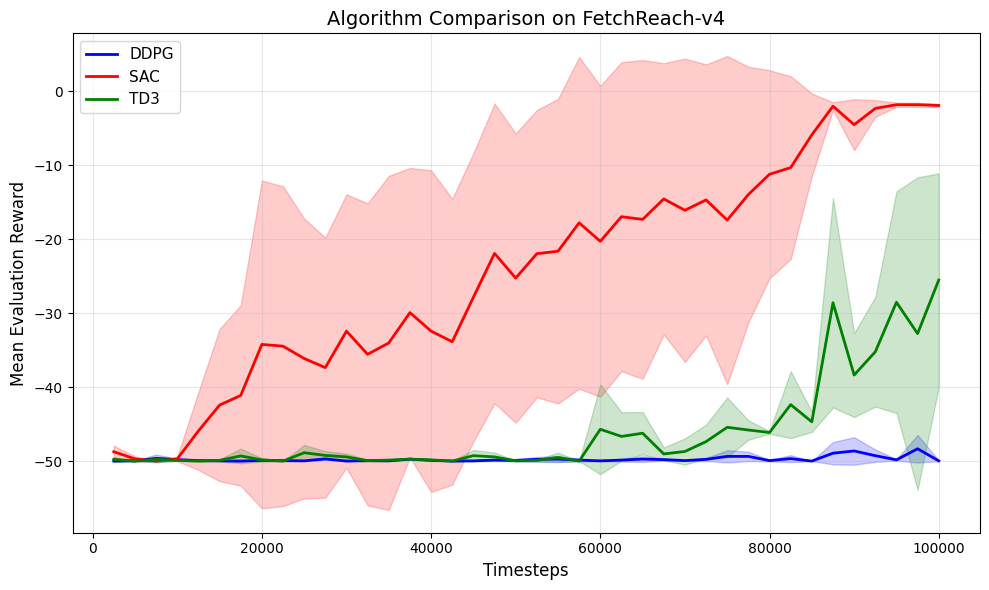

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Configuration ===
ALGORITHMS = ["ddpg", "sac", "td3"]
ENV = "FetchReach-v4"
N_SEEDS = 3  # We will try to find the N most recent runs

def get_latest_run_folders(algo, env, n_runs):
    """
    Finds all run folders for an algo/env, sorts them by ID, 
    and returns the last n_runs (the most recent ones).
    """
    base_path = Path(f"logs/{algo}")
    if not base_path.exists():
        print(f"Warning: Folder {base_path} does not exist.")
        return []

    # Find all folders matching "FetchReachDense-v4_*"
    # This finds v4_0, v4_1, v4_8, etc.
    folders = list(base_path.glob(f"{env}_*"))
    
    # Sort folders by the integer suffix (the ID)
    # e.g., "FetchReachDense-v4_10" -> 10
    def get_run_id(folder_path):
        try:
            return int(folder_path.name.split('_')[-1])
        except ValueError:
            return -1

    folders.sort(key=get_run_id)

    # Select the last 'n_runs' folders (the most recent ones)
    selected_folders = folders[-n_runs:] if len(folders) >= n_runs else folders
    
    if len(selected_folders) < n_runs:
        print(f"Note: Only found {len(selected_folders)} runs for {algo} (expected {n_runs}).")
    
    print(f"[{algo.upper()}] Loading data from: {[f.name for f in selected_folders]}")
    return selected_folders

# === Plotting ===
fig, ax = plt.subplots(figsize=(10, 6))
colors = {"ddpg": "blue", "sac": "red", "td3": "green"}

for algo in ALGORITHMS:
    all_rewards = []
    all_timesteps = None
    
    # 1. Dynamically find the correct folders
    run_folders = get_latest_run_folders(algo, ENV, N_SEEDS)
    
    # 2. Load data from those specific folders
    for folder in run_folders:
        eval_path = folder / "evaluations.npz"
        
        if eval_path.exists():
            try:
                data = np.load(eval_path)
                timesteps = data["timesteps"]
                rewards = data["results"].mean(axis=1) # Mean over evaluation episodes
                
                all_rewards.append(rewards)
                
                # Use the timesteps from the first valid run as reference
                if all_timesteps is None:
                    all_timesteps = timesteps
            except Exception as e:
                print(f"Error loading {eval_path}: {e}")
        else:
            print(f"Warning: {eval_path} not found")

    # 3. Process and Plot
    if all_rewards:
        # Truncate to shortest length (in case one run stopped early)
        min_len = min(len(r) for r in all_rewards)
        all_rewards = np.array([r[:min_len] for r in all_rewards])
        
        # Ensure timesteps match the truncated length
        # (Handle case where all_timesteps might be longer than min_len)
        current_timesteps = all_timesteps[:min_len]
        
        mean = all_rewards.mean(axis=0)
        std = all_rewards.std(axis=0)
        
        ax.plot(current_timesteps, mean, label=algo.upper(), color=colors[algo], linewidth=2)
        ax.fill_between(current_timesteps, mean - std, mean + std, alpha=0.2, color=colors[algo])
    else:
        print(f"Skipping {algo} (No data found)")

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Mean Evaluation Reward", fontsize=12)
ax.set_title(f"Algorithm Comparison on {ENV}", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("algorithm_comparison_fixed.png", dpi=150)
print("\nPlot saved as algorithm_comparison_fixed.png")
plt.show()

# Task 1.4

HER Hyperparameter files created in hyperparams_her!

Training DDPG + HER - Seed 0

Training DDPG + HER - Seed 1

Training DDPG + HER - Seed 2

Training TD3 + HER - Seed 0

Training TD3 + HER - Seed 1

Training TD3 + HER - Seed 2

All HER training complete!
[DDPG] Loading data from: ['FetchReach-v4_1', 'FetchReach-v4_2', 'FetchReach-v4_3']
[TD3] Loading data from: ['FetchReach-v4_1', 'FetchReach-v4_2', 'FetchReach-v4_3']

Plot saved as her_algorithm_comparison.png


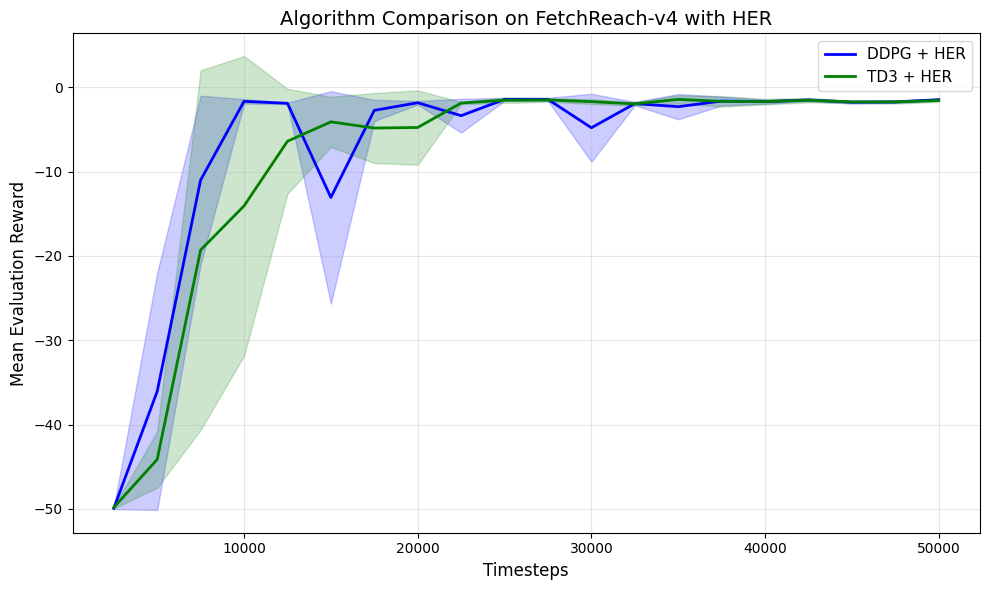

In [1]:
import yaml
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Config ===
# Task 1.4: "Combine HER with at least two selected algorithms"
ALGORITHMS = ["ddpg", "td3"] 
N_SEEDS = 3
ENV = "FetchReach-v4"
N_TIMESTEPS = 50000  # HER learns much faster, so 50k is usually sufficient

# === 1. Create directory for HER configs ===
hyperparams_dir = Path("hyperparams_her")
hyperparams_dir.mkdir(parents=True, exist_ok=True)

# === 2. Define Hyperparameters (NOW WITH HER) ===
# We add 'replay_buffer_class': 'HerReplayBuffer' to enable Hindsight Experience Replay
configs = {
    "ddpg": {
        ENV: {
            'n_timesteps': N_TIMESTEPS,
            'policy': 'MultiInputPolicy',
            
            # --- HER CONFIGURATION ---
            'replay_buffer_class': 'HerReplayBuffer',
            'replay_buffer_kwargs': "dict(n_sampled_goal=4, goal_selection_strategy='future')",
            # -------------------------

            'noise_type': 'ornstein-uhlenbeck',
            'noise_std': 0.37169319553029,
            'gradient_steps': 1,
            'train_freq': 1,
            'learning_rate': 0.0010108124085550568,
            'batch_size': 256,
            'policy_kwargs': "dict(net_arch=[400, 300])",
        }
    },
    "td3": {
        ENV: {
            'n_timesteps': N_TIMESTEPS,
            'policy': 'MultiInputPolicy',

            # --- HER CONFIGURATION ---
            'replay_buffer_class': 'HerReplayBuffer',
            'replay_buffer_kwargs': "dict(n_sampled_goal=4, goal_selection_strategy='future')",
            # -------------------------

            'noise_type': 'ornstein-uhlenbeck',
            'noise_std': 0.37169319553029,
            'gradient_steps': 1,
            'train_freq': 1,
            'learning_rate': 0.0010108124085550568,
            'batch_size': 256,
            'policy_kwargs': "dict(net_arch=[400, 300])",
        }
    },
}

# Write the config files
for algo, config in configs.items():
    with open(hyperparams_dir / f'{algo}.yml', 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

print(f"HER Hyperparameter files created in {hyperparams_dir}!")

# === 3. Train all algorithms ===
# Using sys.executable to ensure we use the current python environment
python_executable = sys.executable 

for algo in ALGORITHMS:
    for seed in range(N_SEEDS):
        print(f"\n{'='*50}")
        print(f"Training {algo.upper()} + HER - Seed {seed}")
        print('='*50)
        
        # We point to the new hyperparams_her folder and save to logs_her
        command = [
            python_executable, "-m", "rl_zoo3.train",
            "--algo", algo,
            "--env", ENV,
            "--gym-packages", "gymnasium_robotics",
            "-c", str(hyperparams_dir / f"{algo}.yml"),
            "--seed", str(seed),
            "--eval-freq", "2500",
            "--eval-episodes", "10",
            "-f", "logs_her",  # <--- Saving to a new folder
            "--verbose", "1"
        ]
        
        try:
            subprocess.run(command, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error training {algo}: {e}")

print("\nAll HER training complete!")

# === 4. Plotting (Updated for HER logs) ===
# This function is updated to look into 'logs_her' instead of 'logs'
def get_latest_run_folders(algo, env, n_runs):
    base_path = Path(f"logs_her/{algo}") # <--- Changed to logs_her
    if not base_path.exists():
        print(f"Warning: Folder {base_path} does not exist.")
        return []

    folders = list(base_path.glob(f"{env}_*"))
    
    def get_run_id(folder_path):
        try:
            return int(folder_path.name.split('_')[-1])
        except ValueError:
            return -1

    folders.sort(key=get_run_id)
    selected_folders = folders[-n_runs:] if len(folders) >= n_runs else folders
    
    print(f"[{algo.upper()}] Loading data from: {[f.name for f in selected_folders]}")
    return selected_folders

fig, ax = plt.subplots(figsize=(10, 6))
colors = {"ddpg": "blue", "td3": "green"} # Removed SAC color

for algo in ALGORITHMS:
    all_rewards = []
    all_timesteps = None
    
    run_folders = get_latest_run_folders(algo, ENV, N_SEEDS)
    
    for folder in run_folders:
        eval_path = folder / "evaluations.npz"
        
        if eval_path.exists():
            try:
                data = np.load(eval_path)
                timesteps = data["timesteps"]
                rewards = data["results"].mean(axis=1)
                
                all_rewards.append(rewards)
                
                if all_timesteps is None:
                    all_timesteps = timesteps
            except Exception as e:
                print(f"Error loading {eval_path}: {e}")
        else:
            print(f"Warning: {eval_path} not found")

    if all_rewards:
        min_len = min(len(r) for r in all_rewards)
        all_rewards = np.array([r[:min_len] for r in all_rewards])
        current_timesteps = all_timesteps[:min_len]
        
        mean = all_rewards.mean(axis=0)
        std = all_rewards.std(axis=0)
        
        ax.plot(current_timesteps, mean, label=f"{algo.upper()} + HER", color=colors[algo], linewidth=2)
        ax.fill_between(current_timesteps, mean - std, mean + std, alpha=0.2, color=colors[algo])
    else:
        print(f"Skipping {algo} (No data found)")

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Mean Evaluation Reward", fontsize=12)
ax.set_title(f"Algorithm Comparison on {ENV} with HER", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("her_algorithm_comparison.png", dpi=150)
print("\nPlot saved as her_algorithm_comparison.png")
plt.show()

# Task 1.5

In [2]:
# Update the -f flag to point to your specific folder
!python record_video.py --algo ddpg --env FetchReachDense-v4 -f logs/ --exp-id 5 -n 1000

Loading logs/ddpg\FetchReachDense-v4_5\FetchReachDense-v4.zip
Loading logs/ddpg\FetchReachDense-v4_5\FetchReachDense-v4.zip
Saving video to c:\Users\robin\Desktop\SituatedAI\proj_situated_2\src\robotics_rl\logs\ddpg\FetchReachDense-v4_5\videos\final-model-ddpg-FetchReachDense-v4-step-0-to-step-1000.mp4
MoviePy - Building video c:\Users\robin\Desktop\SituatedAI\proj_situated_2\src\robotics_rl\logs\ddpg\FetchReachDense-v4_5\videos\final-model-ddpg-FetchReachDense-v4-step-0-to-step-1000.mp4.
MoviePy - Writing video c:\Users\robin\Desktop\SituatedAI\proj_situated_2\src\robotics_rl\logs\ddpg\FetchReachDense-v4_5\videos\final-model-ddpg-FetchReachDense-v4-step-0-to-step-1000.mp4

MoviePy - Done !
MoviePy - video ready c:\Users\robin\Desktop\SituatedAI\proj_situated_2\src\robotics_rl\logs\ddpg\FetchReachDense-v4_5\videos\final-model-ddpg-FetchReachDense-v4-step-0-to-step-1000.mp4



frame_index:  64%|██████▎   | 636/1001 [00:00<00:00, 3309.63it/s, now=None]
                                                                           


In [3]:
import base64
from pathlib import Path
from IPython import display as ipythondisplay

def show_videos(video_path, prefix=""):
    """Display MP4 videos from a folder in the notebook."""
    html = []
    for mp4 in Path(video_path).glob(f"{prefix}*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes()).decode('ascii')
        html.append(f'''<video alt="{mp4}" autoplay loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{video_b64}" type="video/mp4" />
        </video>''')
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [4]:
show_videos('logs/ddpg/FetchReachDense-v4_5/videos/')